In [1]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
from calen import create_date_list
import matplotlib.ticker as mtick

2024-04-01
2024-06-04
['2024-04-01', '2024-04-02', '2024-04-03', '2024-04-08', '2024-04-09', '2024-04-10', '2024-04-11', '2024-04-12', '2024-04-15', '2024-04-16', '2024-04-17', '2024-04-18', '2024-04-19', '2024-04-22', '2024-04-23', '2024-04-24', '2024-04-25', '2024-04-26', '2024-04-29', '2024-04-30', '2024-05-06', '2024-05-07', '2024-05-08', '2024-05-09', '2024-05-10', '2024-05-13', '2024-05-14', '2024-05-15', '2024-05-16', '2024-05-17', '2024-05-20', '2024-05-21', '2024-05-22', '2024-05-23', '2024-05-24', '2024-05-27', '2024-05-28', '2024-05-29', '2024-05-30', '2024-05-31', '2024-06-03', '2024-06-04']


In [2]:
class Portfolio:
    def __init__(self):
        self.holdings = {}
        self.initial_cash = 0
        self.cash = 0
        self.pnl_history = []
        self.dates = []
        self.trade_log = []
        self.fee_rate = 0.00005  # 交易手续费率万0.5
        self.max_drawdown = 0
        self.peak = 0

    def initialize(self, bonds, initial_cash):
        # 初始化持仓
        num_bonds = len(bonds)
        equal_allocation = initial_cash / num_bonds
        self.holdings = {}
        self.initial_cash = initial_cash
        self.cash = initial_cash

        for bond in bonds['代码']:
            bond_data = bonds[bonds['代码'] == bond]
            if not bond_data.empty:
                buy_price = bond_data['收盘价'].iloc[0]
                transaction_amount = equal_allocation / (1 + self.fee_rate)  # 包含手续费的金额
                quantity = transaction_amount // buy_price
                actual_transaction_amount = quantity * buy_price
                fee = actual_transaction_amount * self.fee_rate
                self.holdings[bond] = {'数量': quantity, '买价': buy_price}
                self.cash -= (actual_transaction_amount + fee)
                self.trade_log.append({
                    '代码': bond,
                    '日期': bonds['日期'].iloc[0],
                    '动作': '买入',
                    '数量': quantity,
                    '价格': buy_price,
                    '手续费': fee
                })

    def update_holdings(self, new_bonds, df):
        new_bonds_set = set(new_bonds['代码'])
        current_bonds_set = set(self.holdings.keys())

        bonds_to_sell = current_bonds_set - new_bonds_set
        for bond in bonds_to_sell:
            bond_data = df[df['代码'] == bond]
            if not bond_data.empty:
                sell_price = bond_data['收盘价'].iloc[0]
                quantity = self.holdings[bond]['数量']
                transaction_amount = quantity * sell_price
                fee = transaction_amount * self.fee_rate
                self.cash += transaction_amount  # 卖出债券后现金增加
                self.cash -= fee  # 扣除卖出手续费
                self.trade_log.append({
                    '代码': bond,
                    '日期': df['日期'].iloc[0],
                    '动作': '卖出',
                    '数量': quantity,
                    '价格': sell_price,
                    '手续费': fee
                })
                del self.holdings[bond]

        bonds_to_buy = new_bonds_set - current_bonds_set
        num_new_bonds = len(bonds_to_buy)

        if num_new_bonds > 0:
            equal_allocation = self.cash / num_new_bonds
            for bond in new_bonds['代码']:
                if bond in bonds_to_buy:
                    bond_data = df[df['代码'] == bond]
                    if not bond_data.empty:
                        buy_price = bond_data['收盘价'].iloc[0]
                        transaction_amount = equal_allocation / (1 + self.fee_rate)  # 包含手续费的金额
                        quantity = transaction_amount // buy_price
                        actual_transaction_amount = quantity * buy_price
                        fee = actual_transaction_amount * self.fee_rate
                        self.holdings[bond] = {'数量': quantity, '买价': buy_price}
                        self.cash -= (actual_transaction_amount + fee)
                        self.trade_log.append({
                            '代码': bond,
                            '日期': df['日期'].iloc[0],
                            '动作': '买入',
                            '数量': quantity,
                            '价格': buy_price,
                            '手续费': fee
                        })

    def calculate_portfolio_value(self, df, date):
        print('手头现金：', self.cash)
        total_value = self.cash
        for bond in self.holdings:
            bond_data = df[df['代码'] == bond]
            if not bond_data.empty:
                # print(11111111111111111111111111111111111111111111)
                total_value += bond_data['收盘价'].iloc[0] * self.holdings[bond]['数量']
        return total_value

    def update_pnl_history(self, df, date):
        current_value = self.calculate_portfolio_value(df, date)
        print('当前总资产：', current_value)
        current_pnl = (current_value - self.initial_cash) / self.initial_cash  # 计算相对于初始资金的百分比
        self.pnl_history.append(current_pnl)
        self.dates.append(date)
        print(f"PNL on {date}: {current_pnl:.2f}%")

        # 更新最大回撤
        if current_value > self.peak:
            self.peak = current_value
        drawdown = (self.peak - current_value) / self.peak
        if drawdown > self.max_drawdown:
            self.max_drawdown = drawdown

    def close_all_positions(self, df, date):
        total_value = self.cash
        print('手头现金：', self.cash)
        for bond in list(self.holdings.keys()):
            # print(bond)
            bond_data = df[df['代码'] == bond]
            if not bond_data.empty:
                # print(1)
                sell_price = bond_data['收盘价'].iloc[0]
                quantity = self.holdings[bond]['数量']
                transaction_amount = quantity * sell_price
                fee = transaction_amount * self.fee_rate
                total_value += transaction_amount  # 卖出债券后现金增加
                total_value -= fee  # 扣除卖出手续费
                self.trade_log.append({
                    '代码': bond,
                    '日期': date,
                    '动作': '卖出',
                    '数量': quantity,
                    '价格': sell_price,
                    '手续费': fee
                })
                del self.holdings[bond]
        print('当前总资产：', total_value)
        return total_value


In [3]:
class DoubleLowStrategy:
    def __init__(self, db_file, start_date, end_date):
        self.con = duckdb.connect(db_file)
        self.portfolio = Portfolio()
        self.trading_days = create_date_list(start_date, end_date)

    def get_data_for_specific_date(self, target_date):
        query = f"""
        SELECT * FROM cb_daily
        WHERE 日期 = '{target_date}'
        """
        df = self.con.execute(query).df()
        return df

    def double_low_strategy(self, df, nums):    # 选债
        filtered_df = df[
            (df['收盘价'] >= 110) &
            (df['收盘价'] <= 140) &
            (df['转股溢价率'] < 40) &
            (df['剩余年限'] > 1.5) &
            (df['剩余规模（亿元）'] < 10) &
            (df['上浮成本'] <= 5) &
            (df['强赎指标'] < 10)
        ]
        top_bonds = filtered_df.nsmallest(nums, '双低').reset_index(drop=True)
        return top_bonds

    def run_backtest(self, rotation_period_days, initial_investment, nums):
        current_date = self.trading_days[0]
        end_date = self.trading_days[-1]

        # 获取初始日期的交易数据
        daily_df = self.get_data_for_specific_date(current_date)
        if daily_df.empty:
            print(current_date)
            raise ValueError("No data available for the start date")

        top_bonds_df = self.double_low_strategy(daily_df, nums)
        self.portfolio.initialize(top_bonds_df, initial_investment)
        print(f"当前持仓：{self.portfolio.holdings}")

        # 确定下一个交易日的日期
        current_date = self.get_next_trading_day(current_date, rotation_period_days)

        while current_date < end_date:
            daily_df = self.get_data_for_specific_date(current_date)
            if daily_df.empty:
                print(current_date)
                raise ValueError("No data available for the current date")
            top_bonds_df = self.double_low_strategy(daily_df, nums)
            self.portfolio.update_holdings(top_bonds_df, daily_df)
            print(f"当前持仓：{self.portfolio.holdings}")
            self.portfolio.update_pnl_history(daily_df, current_date)
            current_date = self.get_next_trading_day(current_date, rotation_period_days)

        final_value = self.portfolio.close_all_positions(daily_df, current_date)
        final_pnl = (final_value / initial_investment - 1) * 100
        print(f"Final PNL on {current_date}: {final_pnl:.2f}%")
                
        self.con.close()
        self.plot_pnl()
        self.print_trade_log()
        self.print_max_drawdown()

    def get_next_trading_day(self, current_date, offset_days):
        current_index = self.trading_days.index(current_date)
        next_index = current_index + offset_days
        if next_index >= len(self.trading_days):
            return self.trading_days[-1]  # 返回最后一个交易日
        return self.trading_days[next_index]

    def plot_pnl(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.portfolio.dates, self.portfolio.pnl_history, label='PNL')
        plt.xlabel('Time (days)')
        plt.ylabel('PNL (%)')
        plt.title('PNL Over Time')
        plt.legend()
        plt.grid(True)

        # 将纵轴格式化为百分比
        ax = plt.gca()
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=2))

        plt.show()

    def print_trade_log(self):
        trade_log_df = pd.DataFrame(self.portfolio.trade_log)
        print(trade_log_df)
    
    def print_max_drawdown(self):
        print(f"Maximum Drawdown: {self.portfolio.max_drawdown * 100:.2f}%")

2023-01-01
2023-02-28
当前持仓：{128087: {'数量': 409.0, '买价': 122.101}, 110084: {'数量': 421.0, '买价': 118.527}, 128130: {'数量': 436.0, '买价': 114.475}, 113631: {'数量': 432.0, '买价': 115.683}, 127028: {'数量': 406.0, '买价': 123.12}, 127060: {'数量': 424.0, '买价': 117.771}, 128119: {'数量': 428.0, '买价': 116.611}, 128083: {'数量': 416.0, '买价': 120.127}, 113570: {'数量': 409.0, '买价': 122.08}, 113591: {'数量': 423.0, '买价': 117.933}, 123129: {'数量': 453.0, '买价': 110.131}, 127042: {'数量': 451.0, '买价': 110.64}, 127029: {'数量': 403.0, '买价': 123.9}, 113640: {'数量': 438.0, '买价': 113.901}, 123063: {'数量': 428.0, '买价': 116.645}, 128133: {'数量': 419.0, '买价': 119.18}, 123089: {'数量': 407.0, '买价': 122.611}, 123146: {'数量': 448.0, '买价': 111.526}, 123162: {'数量': 410.0, '买价': 121.794}, 113567: {'数量': 377.0, '买价': 132.382}}
当前持仓：{110084: {'数量': 421.0, '买价': 118.527}, 113631: {'数量': 432.0, '买价': 115.683}, 127028: {'数量': 406.0, '买价': 123.12}, 127060: {'数量': 424.0, '买价': 117.771}, 128119: {'数量': 428.0, '买价': 116.611}, 113591: {'数量': 423.0, '

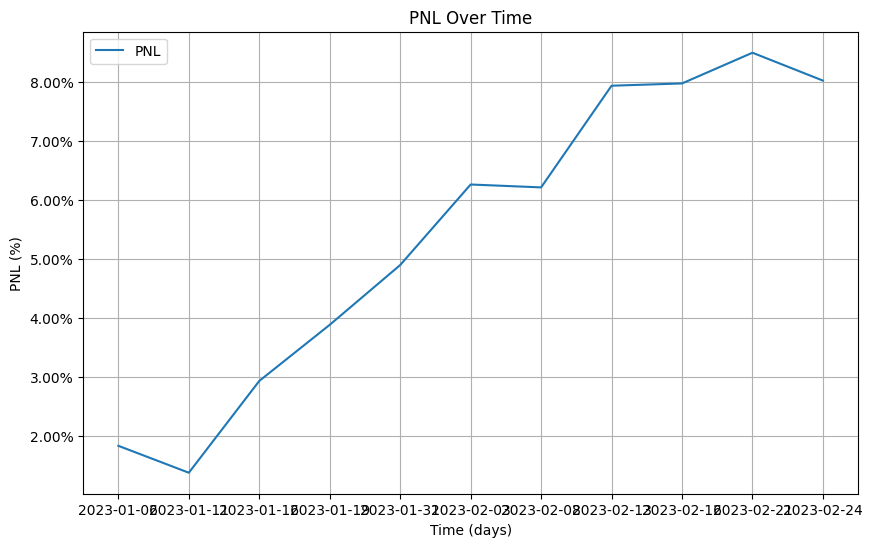

         代码          日期  动作     数量       价格       手续费
0    128087  2023-01-03  买入  409.0  122.101  2.496965
1    110084  2023-01-03  买入  421.0  118.527  2.494993
2    128130  2023-01-03  买入  436.0  114.475  2.495555
3    113631  2023-01-03  买入  432.0  115.683  2.498753
4    127028  2023-01-03  买入  406.0  123.120  2.499336
..      ...         ...  ..    ...      ...       ...
189  113524  2023-02-28  卖出   26.0  119.001  0.154701
190  127059  2023-02-28  卖出   24.0  129.000  0.154800
191  127055  2023-02-28  卖出   26.0  118.000  0.153400
192  123160  2023-02-28  卖出   26.0  117.805  0.153147
193  111011  2023-02-28  卖出   23.0  134.525  0.154704

[194 rows x 6 columns]
Maximum Drawdown: 0.45%


In [4]:
db_file = '/Users/xiqia/Desktop/双低策略/cb_daily.duckdb'   # 数据库文件
start_date = '2023-01-01'   # 回测开始日期
end_date = '2023-2-28'    # 回测结束日期
rotation_period_days = 3    # 换仓周期
initial_investment = 1000000    # 初始资金一百万

strategy = DoubleLowStrategy(db_file, start_date, end_date)
strategy.run_backtest(rotation_period_days, initial_investment, nums=20)    # 每次选取20只双低债券

2023-01-01
2024-06-04
当前持仓：{128087: {'数量': 409.0, '买价': 122.101}, 110084: {'数量': 421.0, '买价': 118.527}, 128130: {'数量': 436.0, '买价': 114.475}, 113631: {'数量': 432.0, '买价': 115.683}, 127028: {'数量': 406.0, '买价': 123.12}, 127060: {'数量': 424.0, '买价': 117.771}, 128119: {'数量': 428.0, '买价': 116.611}, 128083: {'数量': 416.0, '买价': 120.127}, 113570: {'数量': 409.0, '买价': 122.08}, 113591: {'数量': 423.0, '买价': 117.933}, 123129: {'数量': 453.0, '买价': 110.131}, 127042: {'数量': 451.0, '买价': 110.64}, 127029: {'数量': 403.0, '买价': 123.9}, 113640: {'数量': 438.0, '买价': 113.901}, 123063: {'数量': 428.0, '买价': 116.645}, 128133: {'数量': 419.0, '买价': 119.18}, 123089: {'数量': 407.0, '买价': 122.611}, 123146: {'数量': 448.0, '买价': 111.526}, 123162: {'数量': 410.0, '买价': 121.794}, 113567: {'数量': 377.0, '买价': 132.382}}
当前持仓：{113631: {'数量': 432.0, '买价': 115.683}, 128119: {'数量': 428.0, '买价': 116.611}, 127042: {'数量': 451.0, '买价': 110.64}, 123146: {'数量': 448.0, '买价': 111.526}, 128128: {'数量': 384.0, '买价': 134.8}, 111002: {'数量': 383.0, '买价

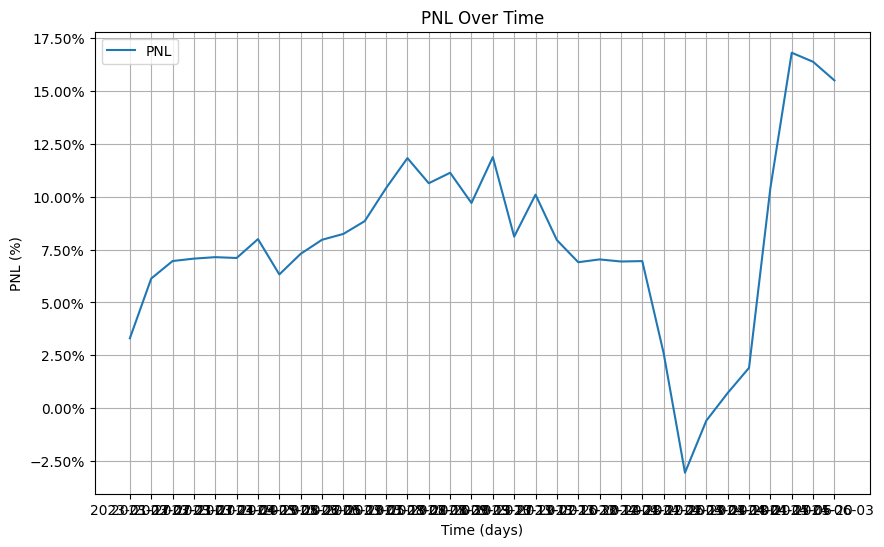

         代码          日期  动作     数量       价格       手续费
0    128087  2023-01-03  买入  409.0  122.101  2.496965
1    110084  2023-01-03  买入  421.0  118.527  2.494993
2    128130  2023-01-03  买入  436.0  114.475  2.495555
3    113631  2023-01-03  买入  432.0  115.683  2.498753
4    127028  2023-01-03  买入  406.0  123.120  2.499336
..      ...         ...  ..    ...      ...       ...
568  128120  2024-06-04  卖出  322.0  119.249  1.919909
569  127053  2024-06-04  卖出  313.0  122.725  1.920646
570  111007  2024-06-04  卖出  309.0  124.459  1.922892
571  128132  2024-06-04  卖出  333.0  115.300  1.919745
572  111008  2024-06-04  卖出  319.0  120.343  1.919471

[573 rows x 6 columns]
Maximum Drawdown: 13.35%


In [5]:
db_file = '/Users/xiqia/Desktop/双低/cb_daily.duckdb'   # 数据库文件
start_date = '2023-01-01'   # 回测开始日期
end_date = '2024-6-4'    # 回测结束日期
rotation_period_days = 10    # 换仓周期
initial_investment = 1000000    # 初始资金一百万

strategy = DoubleLowStrategy(db_file, start_date, end_date)
strategy.run_backtest(rotation_period_days, initial_investment, nums=20)    # 每次选取20只双低债券